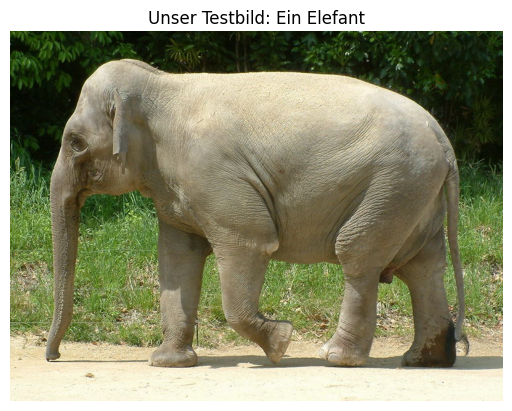

In [1]:
import torch
import torchvision
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import json

# Lade ein vortrainiertes ResNet50-Modell und setze es in den Evaluationsmodus
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()

# Definiere die Transformationen: Bildgröße anpassen, in Tensor umwandeln und normalisieren
# Diese Normalisierungswerte sind Standard für Modelle, die auf ImageNet trainiert wurden
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Lade das gleiche Beispielbild
img_url = 'https://upload.wikimedia.org/wikipedia/commons/f/f9/Zoorashia_elephant.jpg'
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(img_url, headers=headers)
img_pil = Image.open(BytesIO(response.content)).convert('RGB') # Stelle sicher, dass es RGB ist

# Wende die Transformationen an
img_tensor = transform(img_pil).unsqueeze(0) # Füge eine Batch-Dimension hinzu

# Zeige das Originalbild (vor der Normalisierung) an
plt.imshow(img_pil)
plt.title("Unser Testbild: Ein Elefant")
plt.axis('off')
plt.show()

In [2]:
# Lade die ImageNet-Klassennamen
class_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

# --- KORREKTUR ---
# Verwende die .json()-Methode von requests, um die Antwort direkt zu dekodieren
class_idx = requests.get(class_url).json() 
# --- KORREKTUR ENDE ---

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

# Mache eine Vorhersage (ohne Gradientenberechnung für mehr Geschwindigkeit)
with torch.no_grad():
    output = model(img_tensor)

# Konvertiere die Ausgabe in Wahrscheinlichkeiten und finde die Top 3
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_catid = torch.topk(probabilities, 3)

print("Top 3 Vorhersagen des Modells:")
for i in range(top3_prob.size(0)):
    label = idx2label[top3_catid[i]]
    score = top3_prob[i].item()
    print(f"{i+1}: {label} ({score:.2f})")

Top 3 Vorhersagen des Modells:
1: Indian_elephant (0.94)
2: tusker (0.02)
3: African_elephant (0.02)


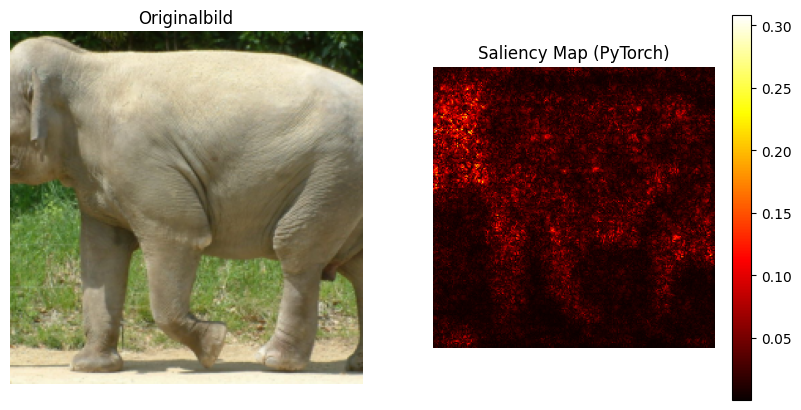

In [3]:
# Setze 'requires_grad' für unseren Input-Tensor, damit wir den Gradienten berechnen können
img_tensor.requires_grad_()

# Führe das Bild nochmal durchs Modell (diesmal mit Gradientenberechnung)
output = model(img_tensor)
output_max = output.max() # Wir interessieren uns für den Gradienten der stärksten Aktivierung

# Berechne den Gradienten
output_max.backward()

# Hole den Gradienten und verarbeite ihn für die Visualisierung
saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
saliency = saliency.squeeze(0) # Entferne die Batch-Dimension

# Visualisierung
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Wir müssen die Transformationen für die Anzeige rückgängig machen
unnormalized_img = img_tensor.squeeze(0).detach().numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalized_img = std * unnormalized_img + mean
unnormalized_img = np.clip(unnormalized_img, 0, 1)

axs[0].imshow(unnormalized_img)
axs[0].set_title('Originalbild')
axs[0].axis('off')

im = axs[1].imshow(saliency, cmap='hot')
axs[1].set_title('Saliency Map (PyTorch)')
axs[1].axis('off')
fig.colorbar(im, ax=axs[1])
plt.show()